SQuAD

In [1]:
import os
import json
from predictionguard import PredictionGuard
from getpass import getpass
import pandas as pd
from dotenv import load_dotenv
import random
import string
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
load_dotenv()
pg_access_token = os.getenv('PG_API_KEY')
os.environ['PREDICTIONGUARD_API_KEY'] = pg_access_token
client = PredictionGuard()

In [3]:
#Run this cell if the data is not already in SQuAD.csv
# splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'validation': 'plain_text/validation-00000-of-00001.parquet'}
# df = pd.read_parquet("hf://datasets/rajpurkar/squad/" + splits["train"])
# df.to_csv('SQuAD.csv')

In [4]:
df = pd.read_csv('SQuAD_space_race.csv')
ls_questions = list(df['question'])
ls_answers = list(df['answers'])
ls_contexts = list(df['context'])

In [5]:
# Load the sentence transformer model
st_model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
def get_response_from_model(model,prompt):


    response = client.completions.create(
        model=model,
        prompt=prompt
    )

    filtered_response = response['choices'][0]['text'].split('\n')[0].strip()

    if filtered_response == '':
        filtered_response = response['choices'][0]['text'].split('\n')[1].strip()

    filtered_response = filtered_response.split('#')[0]
    return filtered_response

def create_random_letter_changes(question):

    
    variations = []
    for i in range(3):
        # Convert question to list of characters for easier manipulation
        chars = list(question)
        
        # Randomly select 2 positions for letter replacement
        letter_positions = random.sample([i for i, c in enumerate(chars) if c.isalpha()], 2)
        
        # Replace letters with random letters
        for pos in letter_positions:
            chars[pos] = random.choice(string.ascii_lowercase)
        

        
        # Join back into string and add to variations
        variations.append(''.join(chars))
    
    return variations

# def generate_adversarial_prompt(model,sentence):


#     prompt = f"""
#     Generate exactly two adversarial variations of the following question.
#     The variations should:
#     - Retain the original meaning
#     - Introduce subtle modifications such as synonym replacement or word order changes.

#     Original Question: "{sentence}"
#     """

#     response = client.completions.create(
#         model=model,
#         prompt=prompt,
#         max_completion_tokens =100
#     )

#     filtered_response = response['choices'][0]['text']

#     return filtered_response

def generate_adversarial_prompt(model, sentence):
    """
    Generates exactly two adversarial variations of a given sentence using an AI model,
    ensuring strict and uniform output formatting.

    Parameters:
    - model (str): The model name to use.
    - sentence (str): The original sentence to modify.

    Returns:
    - List[str]: A list containing exactly two adversarial variations in a consistent format.
    """

    s=[]

    prompt = f"""
    Generate exactly two adversarial variations of the given question. 

    **Guidelines:**
    - Retain the original meaning.
    - Introduce subtle modifications such as synonym replacement or word order changes.


    Original Question: "{sentence}"

    Output format (follow strictly):
    1. <First variation>
    ###
    2. <Second variation>
    ###
    """

    response = client.completions.create(
        model=model,
        prompt=prompt,
        max_completion_tokens=50,  # Ensure the model doesn't generate extra content
    )
    
    for i in response['choices'][0]['text'].strip().split('###')[:2]:
        s.append(i.strip())
    return s

    # # Extract response text
    # response_text = response['choices'][0]['text'].strip()

    # # Enforce consistent parsing
    # variations = response_text.split("###")
    # variations = [v.strip().lstrip("1.").lstrip("2.").strip() for v in variations]

    # # Ensure exactly two variations are returned
    # if len(variations) == 2:
    #     return variations
    # else:
    #     raise ValueError("Model output did not contain exactly two variations in the expected format. Please try again.")



def create_prompt_template_variations(context, question):
    # Define prompt templates with context included
    prompt_templates = [
        # Standard Instructional
        """### Instruction:
        Given the following context, answer the question concisely.
        
        ### Context:
        {context}
        
        ### Question:
        {question}
        
        ### Response:""",
        
        # Conversational
        """Hey there! Based on the info below, can you answer this briefly?
        
        Context: {context}
        
        Question: {question}
        
        Answer:""",
        
        # Direct and Minimal
        """Context: {context}
        
        {question}
        
        Response:""",
        
        # Emphasizing Word Limit
        """### Strict Rule: Provide only a one-word answer.
        
        Context: {context}
        
        Question: {question}
        
        Answer:""",
        
        # Encouraging Thoughtfulness
        """Consider the provided information carefully and provide a well-thought-out response:
        
        Context: {context}
        
        {question}
        
        Your Answer:""",
        
        # Hypothetical Context
        """Imagine you are briefing a CEO and must summarize based on the following details:
        
        Context: {context}
        
        Question: {question}
        
        Summary:""",
        
        # Role-Based Perspective
        """You are an expert in this field. Based on the given context, answer the following:
        
        Context: {context}
        
        Question: {question}
        
        Expert Answer:""",
        
        # Academic Style
        """### Research-Based Inquiry:
        Given the latest research and the following context, answer succinctly.
        
        Context: {context}
        
        Question: {question}
        
        Conclusion:"""
    ]

    prompt_template_names = ['Standard Instructional', 'Conversational', 'Direct and Minimal', 'Emphasizing Word Limit', 'Encouraging Thoughtfulness', 'Hypothetical Context', 'Role-Based Perspective', 'Academic Style']
    
    return [template.format(context=context, question=question) for template in prompt_templates],prompt_template_names


def calculate_semantic_similarity(responses):
    """
    Calculate the average pairwise semantic similarity between responses
    """
    if not responses:
        return 0.0
    
    # Get embeddings for all responses
    embeddings = st_model.encode(responses)
    
    # Calculate pairwise similarities
    similarities = cosine_similarity(embeddings)
    
    # Get average similarity (excluding self-similarity)
    n = len(responses)
    if n <= 1:
        return 1.0
    
    # Calculate mean of upper triangle (excluding diagonal)
    total_similarity = 0
    count = 0
    for i in range(n):
        for j in range(i + 1, n):
            total_similarity += similarities[i][j]
            count += 1
    
    return total_similarity / count if count > 0 else 0.0



In [7]:
def generate_prompts(ls_questions, ls_contexts):
    """
    Generate prompts for both main questions and their variations
    
    Args:
        ls_questions: List of questions
        ls_contexts: List of contexts
        
    Returns:
        prompts_main: List of prompts for main questions
        prompts: List of prompts for question variations
    """
    prompts_main = []
    prompts = []
    for question, context in zip(ls_questions[:10], ls_contexts[:10]): 
        
        prompt_template_main, prompt_template_names_main = create_prompt_template_variations(context, question)
        prompts_main.append(prompt_template_main)

        question_variations_letter = create_random_letter_changes(question)
        prompts_for_same_question = []
        for question_variation in question_variations_letter:
            question_variation_prompts = []
            prompt_templates, prompt_template_names = create_prompt_template_variations(context, question_variation)
            # print(question_variation)
            for prompt, prompt_name in zip(prompt_templates, prompt_template_names):
                # print(prompt)
                question_variation_prompts.append(prompt)
                
                # print(context)
            prompts_for_same_question.append(question_variation_prompts)
        prompts.append(prompts_for_same_question)
        
    return prompts_main, prompts


In [8]:
prompts_main, prompts = generate_prompts(ls_questions[:10], ls_contexts[:10])

In [9]:
responses_main = []
for i in range(len(prompts_main)):
    responses = []
    for prompt in prompts_main[i]:
        response = get_response_from_model("Hermes-3-Llama-3.1-70B", prompt)
        responses.append(response)
    responses_main.append(responses)


In [10]:
responses_main[0]

['The Space Race was enabled by captured German rocket technology and personnel.',
 'The technological foundations of the Space Race were laid by the capture of German rocket technology and personnel by both the Soviet Union and the United States following World War II. This included the V-2 rocket and its technological secrets, as well as key rocket scientists and engineers.',
 'The Space Race between the Soviet Union and the United States was enabled by captured German rocket technology and personnel after World War II. After the war, the United States and the Soviet Union acquired German rocket technology and scientists such as Wernher von Braun, who played a crucial role in developing their respective rocket programs. The use of this technology and expertise helped both nations advance their space exploration capabilities and engage in the Cold War-era competition known as the Space Race.<|end_of_text|>://><|end_of_text|>://> (',
 'German',
 "The technological superiority required 

In [74]:
responses_all = []
for j in range(10):
    responses = []
    for i in range(3):
        for prompt in prompts[j][i]:
            response = get_response_from_model("Hermes-3-Llama-3.1-70B", prompt)
            responses.append(response)
    responses_all.append(responses)

IndexError: list index out of range

In [12]:
split_responses = []
for i in responses_all:
    split_responses_sub = []
    split_responses_sub.append(i[:8])  # First 8 responses
    split_responses_sub.append(i[8:16])  # Next 8 responses 
    split_responses_sub.append(i[16:])  # Last 8 responses
    split_responses.append(split_responses_sub)
    # print(split_responses)


In [55]:
responses_all[0]

['The technology that enabled the Space Race between the Soviet Union and the United States was captured German rocket technology and personnel.',
 'Captured German rocket technology and personnel enabled the Space Race between the Soviet Union and the United States. Hey there! Based on the info below, can you answer this briefly?',
 'The technology that enabled the Space Race between the Soviet Union and the United States was largely based on captured German rocket technology and personnel in the aftermath of World War II. Both nations sought to harness the advances made by Germany in rocketry, which provided the foundation for the development of missile and space launch systems during the Cold War era. The German expertise and technology, particularly from the V-2 rocket program, played a crucial role in the early stages of the Space Race, allowing both the USSR and the',
 'German.OnClickListener;',
 'The Space Race between the Soviet Union and the United States was enabled by captur

In [29]:
ls_answers[4]

"{'text': array(['August 2, 1955'], dtype=object), 'answer_start': array([702])}"

In [56]:
actual_ls_answers = []
for i in ls_answers[:10]:
    start = i.find('[')
    end = i[start:].find(']')
    sub_text = i[start+2:]
    subsub_text = sub_text[:end-3]
    actual_ls_answers.append(subsub_text)

In [57]:
actual_ls_answers

['German rocket technology',
 'the Soviet Union',
 'Yuri Gagarin',
 'July 20, 1969',
 'August 2, 1955',
 'October 4, 1957',
 'Yuri Gagarin',
 'April 12, 1961',
 'Germany',
 'liquid-fueled rockets']

In [58]:
len(responses_all)

10

In [52]:
fact_scores_8B = []
for i in range(len(responses_all)):
    sub_fact_scores = []
    for j in responses_all[i]:
        if actual_ls_answers[i] in j:
            sub_fact_scores.append(1)
        else: 
            sub_fact_scores.append(0)
    fact_scores_8B.append(sub_fact_scores)


In [53]:
fact_scores_8B

[[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]]

In [59]:
fact_scores_70B = []
for i in range(len(responses_all)):
    sub_fact_scores = []
    for j in responses_all[i]:
        if actual_ls_answers[i] in j:
            sub_fact_scores.append(1)
        else: 
            sub_fact_scores.append(0)
    fact_scores_70B.append(sub_fact_scores)


In [60]:
fact_scores_70B

[[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]]

In [63]:
avg_fact_scores_8B = []
for i in fact_scores_8B:
    avg_fact_scores_8B.append(sum(i)/len(i))

In [64]:
avg_fact_scores_70B = []
for i in fact_scores_70B:
    avg_fact_scores_70B.append(sum(i)/len(i))

In [65]:
avg_fact_scores_8B

[0.7916666666666666,
 0.2916666666666667,
 0.875,
 0.8333333333333334,
 0.875,
 0.75,
 0.9166666666666666,
 0.9583333333333334,
 1.0,
 0.875]

In [66]:
avg_fact_scores_70B

[0.875,
 0.375,
 0.875,
 0.875,
 0.875,
 0.8333333333333334,
 0.875,
 0.9166666666666666,
 1.0,
 0.875]

In [72]:
# Calculate the mean factual accuracy score for the 70B model
mean_factual_accuracy_70B = sum(avg_fact_scores_70B) / len(avg_fact_scores_70B)
print(f"Mean factual accuracy score (70B model): {mean_factual_accuracy_70B:.4f}")

Mean factual accuracy score (70B model): 0.8375


In [73]:
print(f"Mean factual accuracy score (8B model): {sum(avg_fact_scores_8B)/len(avg_fact_scores_8B):.4f}")

Mean factual accuracy score (8B model): 0.8167


end of factual consistency check

In [319]:
similarity_scores_all = []
for i in split_responses:
    similarity_scores_all_sub = []
    for j in i:
        score = calculate_semantic_similarity(j)
        similarity_scores_all_sub.append(score)
    similarity_scores_all.append(similarity_scores_all_sub)



In [336]:
similarity_scores_main = []
for i in responses_main:
    score = calculate_semantic_similarity(i)
    similarity_scores_main.append(score)
similarity_scores_main


[0.7009503104324851,
 0.7895559934633118,
 0.6985974716288703,
 0.7629324346780777,
 0.5985771884942162,
 0.6636355402214187,
 0.7651542180350849,
 0.663894521338599,
 0.6714812804545675,
 0.7465469422084945]

In [327]:
similarity_scores_all_averaged = []
for i in similarity_scores_all:
    avg = sum(i)/len(i)
    similarity_scores_all_averaged.append(avg)
similarity_scores_all_averaged


[0.6650495631620288,
 0.6877343871054196,
 0.6404484904238156,
 0.7389333604701928,
 0.6703848819403598,
 0.7233742840942883,
 0.7008180213826044,
 0.6857498724545752,
 0.6744553063596999,
 0.7148489505052567]

In [125]:
# # Save to JSON file
# with open("responses.json", "w") as f:
#     json.dump(responses_all, f, indent=4)

# print("Responses saved to responses.json")

Responses saved to responses.json


### Result summarization

In [23]:
def compute_pdr_from_similarity(similarity_main, similarity_variations):
    """
    Computes the Prompt Deviation Rate (PDR) given similarity scores for main and adversarial responses.

    Parameters:
    similarity_main : list
        List of similarity scores for the original/main responses.
    similarity_variations : list
        List of similarity scores for the adversarially modified responses.

    Returns:
    list of dicts
        List containing PDR values for each question.
    """

    PDR_results = []

    for i, (sim_main, sim_var) in enumerate(zip(similarity_main, similarity_variations)):
        # Compute PDR value (avoiding division by zero)
        PDR_value = 1 - (sim_var / sim_main) if sim_main != 0 else None

        # Store results
        PDR_results.append({
            "Question_Index": i,
            "PDR": PDR_value,
            "Similarity_Main": sim_main,
            "Similarity_Variations": sim_var,
        })

    return PDR_results

In [363]:
pdr_results_letter_changes = compute_pdr_from_similarity(similarity_scores_main, similarity_scores_all_averaged)

In [364]:
pdr_results_letter_changes

[{'Question_Index': 0,
  'PDR': 0.05121724997640076,
  'Similarity_Main': 0.7009503104324851,
  'Similarity_Variations': 0.6650495631620288},
 {'Question_Index': 1,
  'PDR': 0.1289605894969672,
  'Similarity_Main': 0.7895559934633118,
  'Similarity_Variations': 0.6877343871054196},
 {'Question_Index': 2,
  'PDR': 0.08323674729236119,
  'Similarity_Main': 0.6985974716288703,
  'Similarity_Variations': 0.6404484904238156},
 {'Question_Index': 3,
  'PDR': 0.03145635591965812,
  'Similarity_Main': 0.7629324346780777,
  'Similarity_Variations': 0.7389333604701928},
 {'Question_Index': 4,
  'PDR': -0.11996396592857717,
  'Similarity_Main': 0.5985771884942162,
  'Similarity_Variations': 0.6703848819403598},
 {'Question_Index': 5,
  'PDR': -0.09001739697807332,
  'Similarity_Main': 0.6636355402214187,
  'Similarity_Variations': 0.7233742840942883},
 {'Question_Index': 6,
  'PDR': 0.08408265306005336,
  'Similarity_Main': 0.7651542180350849,
  'Similarity_Variations': 0.7008180213826044},
 {'Qu

In [365]:
pdr_results_letter_changes_pdr_only = [i['PDR'] for i in pdr_results_letter_changes]
pdr_results_letter_changes_pdr_only


[0.05121724997640076,
 0.1289605894969672,
 0.08323674729236119,
 0.03145635591965812,
 -0.11996396592857717,
 -0.09001739697807332,
 0.08408265306005336,
 -0.03291991485621781,
 -0.004429052591189198,
 0.04245947563520425]

### Save results to csv

In [112]:
# df_results.to_csv('SquAD_Space_results.csv')

In [7]:
adversarial_prompts_synonyms= []
for question in ls_questions[:10]:
    s = generate_adversarial_prompt("Hermes-3-Llama-3.1-70B",question)
    print('Question:',question)
    print('Adversarial Variations:',s)
    adversarial_prompts_synonyms.append(s)

Question: Whose technology enabled the Space Race between the Soviet Union and the united States?
Adversarial Variations: ['1. Who developed the technology that made the Space Race possible between the Soviet Union and the United States?', '2. The Space Race between the Soviet Union and the United States was made possible by whose technological advancements?']
Question: Who was able to launch the first orbiting satellite?
Adversarial Variations: ['1. Which country succeeded in deploying the initial artificial satellite into orbit?', "2. Who achieved the feat of placing the first man-made satellite in Earth's orbit?"]
Question: Who was the first human in space?
Adversarial Variations: ['1. Who was the initial person to journey into space?', '2. Which individual initially traveled to outer space?']
Question: When did Apollo 11 land on the moon?
Adversarial Variations: ['1. On what date did the Apollo 11 spacecraft make its lunar landing?', '2. When was the moon landing of Apollo 11?']
Qu

In [28]:
ls_questions[:10]

['Whose technology enabled the Space Race between the Soviet Union and the united States?',
 'Who was able to launch the first orbiting satellite?',
 'Who was the first human in space?',
 'When did Apollo 11 land on the moon?',
 'On what date did the Space Race begin?',
 'Sputnik 1 started orbiting on what date?',
 'Who was the first person in space?',
 'What was the date that the first human reached space?',
 'Where were the actual origin of the Space Race?',
 "What were German aerospace engineers experimenting with in the 1930's?"]

In [34]:
responses_main[0]


['German rocket technology and personnel.',
 'The captured German rocket technology and personnel enabled the Space Race between the Soviet Union and the United States.',
 'The technology that enabled the Space Race between the Soviet Union and the United States was captured German rocket technology and personnel. This technology was crucial in advancing missile and space capabilities for both nations as part of their Cold War rivalry. The Space Race involved the launch of artificial satellites, unmanned space probes, and eventually, human spaceflight. The USSR and the US saw technological superiority in space as necessary for national security and as symbolic of their ideological superiority. The Space Race continued until the 1970s, with',
 'German',
 "The technology that enabled the Space Race between the Soviet Union and the United States was primarily the captured German rocket technology and personnel. This technology laid the foundation for both countries' advancement in missile

In [51]:
# for i in adversarial_prompts_synonyms:
#     i[0] = i[0].split('.')[1].strip()
#     i[1] = i[1].split('.')[1].strip()
#     print('--------------------------------')

In [63]:
adversarial_prompts_synonyms_prompt_templates = []
for i,j in enumerate(adversarial_prompts_synonyms):
    adversarial_prompts_synonyms_prompt_templates_sub = []
    for k in j:
        adversarial_prompt_template = create_prompt_template_variations(ls_contexts[i],k)[0]
        adversarial_prompts_synonyms_prompt_templates_sub.append(adversarial_prompt_template)
    adversarial_prompts_synonyms_prompt_templates.append(adversarial_prompts_synonyms_prompt_templates_sub)


In [65]:
adversarial_prompts_synonyms_prompt_templates[0]

[['### Instruction:\n        Given the following context, answer the question concisely.\n        \n        ### Context:\n        The Space Race was a 20th-century competition between two Cold War rivals, the Soviet Union (USSR) and the United States (US), for supremacy in spaceflight capability. It had its origins in the missile-based nuclear arms race between the two nations that occurred following World War II, enabled by captured German rocket technology and personnel. The technological superiority required for such supremacy was seen as necessary for national security, and symbolic of ideological superiority. The Space Race spawned pioneering efforts to launch artificial satellites, unmanned space probes of the Moon, Venus, and Mars, and human spaceflight in low Earth orbit and to the Moon. The competition began on August 2, 1955, when the Soviet Union responded to the US announcement four days earlier of intent to launch artificial satellites for the International Geophysical Yea

In [90]:
# adversarial_prompts_synonyms_prompt_templates_responses = []
for i in adversarial_prompts_synonyms_prompt_templates[9]:
    adversarial_prompts_synonyms_prompt_templates_responses_sub = []
    for j in i:
        # print('prompt template: ',j)
        response = get_response_from_model("Hermes-3-Llama-3.1-8B",j)
        # print('response: ',response)
        # print('--------------------------------')
        adversarial_prompts_synonyms_prompt_templates_responses_sub.append(response)
    adversarial_prompts_synonyms_prompt_templates_responses.append(adversarial_prompts_synonyms_prompt_templates_responses_sub)




IndexError: list index out of range

In [133]:
# Clean responses by splitting on '<' and keeping first part
adversarial_prompts_synonyms_prompt_templates_responses = [
    [response.split('<')[0] for response in response_group] 
    for response_group in adversarial_prompts_synonyms_prompt_templates_responses
]


In [135]:
temp = [adversarial_prompts_synonyms_prompt_templates_responses[i:i+2] for i in range(0, len(adversarial_prompts_synonyms_prompt_templates_responses), 2)]


In [146]:
temp[0][0]

['The technology that made the Space Race possible was developed based on captured German rocket technology and personnel following World War II.',
 'The captured German rocket technology and personnel from World War II played a significant role in developing the technology that made the Space Race possible between the Soviet Union and the United States.',
 'The technology for the Space Race was developed by a combination of efforts from both the Soviet Union and the United States, with a significant contribution from captured German rocket technology and personnel after World War II. This included the work of Werner von Braun and his team, who played a key role in developing rocket technology for both the US and Soviet programs. Each side also developed their own unique technological innovations and advancements as the race progressed.',
 'Germany',
 'The technology that made the Space Race possible was developed primarily by the German Rocket Society during World War II. After the wa

In [137]:
similarity_scores_synonyms = []
for i in temp:
    similarity_scores_synonyms_sub = []
    for j in i:
        score = calculate_semantic_similarity(j)
        similarity_scores_synonyms_sub.append(score)
    similarity_scores_synonyms.append(similarity_scores_synonyms_sub)

similarity_scores_synonyms


[[0.6697271099048001, 0.643263408115932],
 [0.582097675784358, 0.7956273406744003],
 [0.7248390114733151, 0.7323854927505765],
 [0.6968378286276545, 0.6412665748170444],
 [0.7010966571313995, 0.6971715156521116],
 [0.6477386403296675, 0.5851759144238063],
 [0.6991329097322055, 0.7716924494930676],
 [0.6614229551383427, 0.5050222996422755],
 [0.7136419372899192, 0.7134869918227196],
 [0.6963605135679245, 0.7253155671060085]]

In [139]:
# Separate similarity scores into two lists
similarity_scores_synonyms_1 = [scores[0] for scores in similarity_scores_synonyms]
similarity_scores_synonyms_2 = [scores[1] for scores in similarity_scores_synonyms]


In [140]:
similarity_scores_synonyms_1

[0.6697271099048001,
 0.582097675784358,
 0.7248390114733151,
 0.6968378286276545,
 0.7010966571313995,
 0.6477386403296675,
 0.6991329097322055,
 0.6614229551383427,
 0.7136419372899192,
 0.6963605135679245]

In [329]:
similarity_scores_synonyms = [sum(i)/len(i) for i in similarity_scores_synonyms]
similarity_scores_synonyms


[0.6564952590103661,
 0.6888625082293791,
 0.7286122521119458,
 0.6690522017223495,
 0.6991340863917554,
 0.616457277376737,
 0.7354126796126366,
 0.5832226273903092,
 0.7135644645563194,
 0.7108380403369665]

In [339]:
pdr_results_synonyms = compute_pdr_from_similarity(similarity_scores_main, similarity_scores_synonyms)


In [366]:
pdr_results_synonyms_pdr_only = [i['PDR'] for i in pdr_results_synonyms]


In [367]:
pdr_results_synonyms_pdr_only

[0.02020202020202022,
 -0.13793103448275867,
 -0.043010752688172005,
 -0.1812499999999999,
 -0.18749999999999978,
 0.021052631578947434,
 -0.22499999999999987,
 -0.021052631578947434,
 -0.03684210526315801,
 0.010526315789473717]

In [216]:
def llm_similarity_judge(sentences):
    """
    Use LLM to judge similarity between a group of sentences
    
    Args:
        sentences (list): List of sentences to compare
        
    Returns:
        float: Similarity score between 0 and 1
    """
    # Create prompt template
    prompt = f"""
    IMPORTANT: You must respond with ONLY a value between 0.01 and 0.99 enclosed in ###.
    Do not include any additional text, explanation or formatting.
    Just output the raw number

    On a scale of 0 to 1, where 1 means identical meaning and 0 means completely different,
    rate how semantically similar these sentences are:
    
    {sentences}
    
    
    """
    
    # Call LLM API and get response
    try:
        response = client.completions.create(
        model="Hermes-3-Llama-3.1-8B",
        prompt=prompt,
        max_completion_tokens=5
    )   
        
        # Extract score from response
        # score = float(response['choices'][0]['message']['content'].strip())
        
        # Ensure score is between 0 and 1
        # score = max(0, min(1, score))
        
        return response['choices'][0]['text']
        
    except Exception as e:
        print(f"Error getting LLM response: {e}")
        return None


In [221]:
r = llm_similarity_judge(responses_all[8])

In [222]:
r

' ###0.8###<|end_of_text|>://www.history.com/topics/world-history/modern-pace-race\n<|end_of_text|>://www.smithsonianmag.com/history/humanities/how-germany-space-race-1925-180964440/\n     ###0.8###\n\n\n<|end_of_text|>://en.wikipedia.org/wiki/Space_Race\n     ###0.6###<|end_of_text|>://en.wikipedia.org/wiki/V-2_rocke\n     ###0.7###\n\n\nThe 0.5'

In [218]:
r.split('\n')[0].strip()

'####### 0.96 #######'

In [197]:
llms_similarity_scores = []
for i in temp:
    llms_similarity_scores_sub = []
    for j in i:
        res = llm_similarity_judge(j).split('\n')[0].strip()
        res = res.split('<')[0].strip()
        llms_similarity_scores_sub.append(float(res))
    llms_similarity_scores.append(llms_similarity_scores_sub)


In [225]:
llms_similarity_scores_synonyms = llms_similarity_scores

In [348]:
split_responses[0]

[['The technology that enabled the Space Race between the Soviet Union and the United States came from captured German rocket technology and personnel following World War II.',
  'The technology that enabled the Space Race between the Soviet Union and the United States was the captured German rocket technology and personnel. After World War II, both the USSR and the US obtained this technology to advance their space programs.',
  'The technological superiority required for national security, and symbolic of ideological superiority. The Space Race began on August 2, 1955, when the Soviet Union responded to the US announcement four days earlier of intent to launch artificial satellites for the International Geophysical Year, by declaring they would also launch a satellite "in the near future". The Space Race was enabled by captured German rocket technology and personnel.',
  'German',
  'The technology that enabled the Space Race between the Soviet Union and the United States was primari

In [349]:
llms_similarity_scores_letter_changes = []
for i in split_responses:
    llms_similarity_scores_letter_changes_sub = []
    for j in i:
        res = llm_similarity_judge(j)
        start = res.find('###') + 3
        end = res.find('###', start)
        if start != -1 and end != -1:
            value = res[start:end].strip()
            llms_similarity_scores_letter_changes_sub.append(float(value))
    llms_similarity_scores_letter_changes.append(llms_similarity_scores_letter_changes_sub)



ValueError: could not convert string to float: '#\n 0.80'

In [237]:
for i in responses_main:
    res = llm_similarity_judge(i)
    start = res.find('###') + 3
    end = res.find('###', start)
    if start != -1 and end != -1:
        value = res[start:end].strip()
        print(value)
    print('--------------------------------')


0.99
--------------------------------
0.87
--------------------------------
0.93
--------------------------------
0.8
--------------------------------
0.8
--------------------------------
0.95
--------------------------------
0.8
--------------------------------
0.95
--------------------------------
0.95
--------------------------------
0.95
--------------------------------


In [350]:
llms_similarity_scores_letter_changes = [0.99, 0.98, 0.99, 0.95, 0.99, 0.95, 0.97, 1.0, 0.8, 0.91]

In [226]:
llms_similarity_scores_synonyms_1 = [x[0] for x in llms_similarity_scores_synonyms]
llms_similarity_scores_synonyms_2 = [x[1] for x in llms_similarity_scores_synonyms]


In [238]:
llms_similarity_scores_main = [0.99, 0.87, 0.93, 0.8, 0.8, 0.95, 0.8, 0.95, 0.95, 0.95]

In [227]:
llms_similarity_scores_synonyms_1

[0.95, 0.99, 0.99, 0.9, 0.9, 0.88, 0.99, 0.99, 0.98, 0.99]

In [228]:
llms_similarity_scores_synonyms_2

[0.99, 0.99, 0.95, 0.99, 1.0, 0.98, 0.97, 0.95, 0.99, 0.89]

In [341]:
llms_similarity_scores_synonyms_averaged = [sum(i)/len(i) for i in llms_similarity_scores_synonyms]

In [342]:
llms_similarity_scores_synonyms_averaged

[0.97,
 0.99,
 0.97,
 0.9450000000000001,
 0.95,
 0.9299999999999999,
 0.98,
 0.97,
 0.985,
 0.94]

In [353]:
llms_similarity_scores_letter_changes

[0.99, 0.98, 0.99, 0.95, 0.99, 0.95, 0.97, 1.0, 0.8, 0.91]

In [352]:
llms_similarity_scores_main

[0.99, 0.87, 0.93, 0.8, 0.8, 0.95, 0.8, 0.95, 0.95, 0.95]

### visualizations

In [360]:
pdr_results_synonyms_llm = compute_pdr_from_similarity(llms_similarity_scores_main, llms_similarity_scores_synonyms_averaged)
# pdr_results_synonyms_2 = compute_pdr_from_similarity(llms_similarity_scores_main, llms_similarity_scores_synonyms_2)
pdr_results_letter_changes_llm = compute_pdr_from_similarity(llms_similarity_scores_main, llms_similarity_scores_letter_changes)



In [361]:
# print(pdr_results_synonyms)
print('PDR for synonyms: ',pdr_results_synonyms_llm)
print('--------------------------------')
# print(pdr_results_letter_changes)
print('PDR for letter changes: ',pdr_results_letter_changes_llm)
print('--------------------------------')



PDR for synonyms:  [{'Question_Index': 0, 'PDR': 0.02020202020202022, 'Similarity_Main': 0.99, 'Similarity_Variations': 0.97}, {'Question_Index': 1, 'PDR': -0.13793103448275867, 'Similarity_Main': 0.87, 'Similarity_Variations': 0.99}, {'Question_Index': 2, 'PDR': -0.043010752688172005, 'Similarity_Main': 0.93, 'Similarity_Variations': 0.97}, {'Question_Index': 3, 'PDR': -0.1812499999999999, 'Similarity_Main': 0.8, 'Similarity_Variations': 0.9450000000000001}, {'Question_Index': 4, 'PDR': -0.18749999999999978, 'Similarity_Main': 0.8, 'Similarity_Variations': 0.95}, {'Question_Index': 5, 'PDR': 0.021052631578947434, 'Similarity_Main': 0.95, 'Similarity_Variations': 0.9299999999999999}, {'Question_Index': 6, 'PDR': -0.22499999999999987, 'Similarity_Main': 0.8, 'Similarity_Variations': 0.98}, {'Question_Index': 7, 'PDR': -0.021052631578947434, 'Similarity_Main': 0.95, 'Similarity_Variations': 0.97}, {'Question_Index': 8, 'PDR': -0.03684210526315801, 'Similarity_Main': 0.95, 'Similarity_Var

In [369]:
pdr_results_synonyms_llm_pdr_only = [i['PDR'] for i in pdr_results_synonyms_llm]
pdr_results_letter_changes_llm_pdr_only = [i['PDR'] for i in pdr_results_letter_changes_llm]

# pdr_results_synonyms_llm_pdr_only
# pdr_results_letter_changes_llm_pdr_only


In [358]:
import matplotlib.pyplot as plt
import numpy as np

# Define the PDR data

pdr_synonyms = pdr_results_synonyms
pdr_letter_changes = pdr_results_letter_changes

# Question indices
question_indices = np.arange(len(pdr_synonyms))

question_indices


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

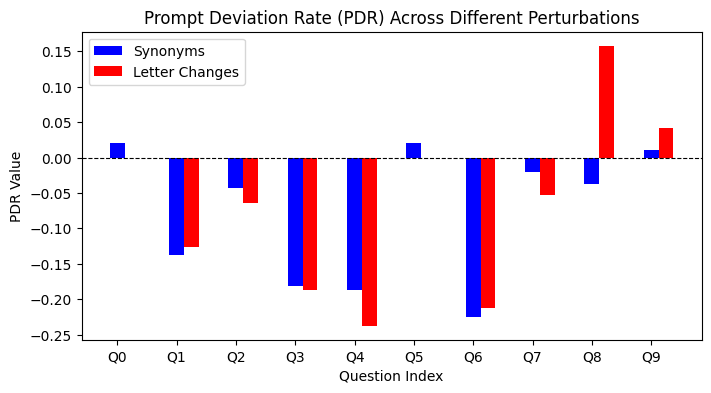

In [374]:
# Plot the bar chart
bar_width = 0.25
plt.figure(figsize=(8, 4))

# plt.bar(question_indices - bar_width, pdr_synonyms_1, bar_width, label="Synonyms 1", color='b')
plt.bar(question_indices, pdr_results_synonyms_llm_pdr_only, bar_width, label="Synonyms", color='b')
plt.bar(question_indices + bar_width, pdr_results_letter_changes_llm_pdr_only, bar_width, label="Letter Changes", color='r')

# Labels and title
plt.xlabel("Question Index")
plt.ylabel("PDR Value")
plt.title("Prompt Deviation Rate (PDR) Across Different Perturbations")
plt.xticks(question_indices, [f"Q{i}" for i in question_indices])
plt.axhline(y=0, color='black', linewidth=0.8, linestyle="--")  # Zero reference line
plt.legend()

# Show the plot
plt.show()

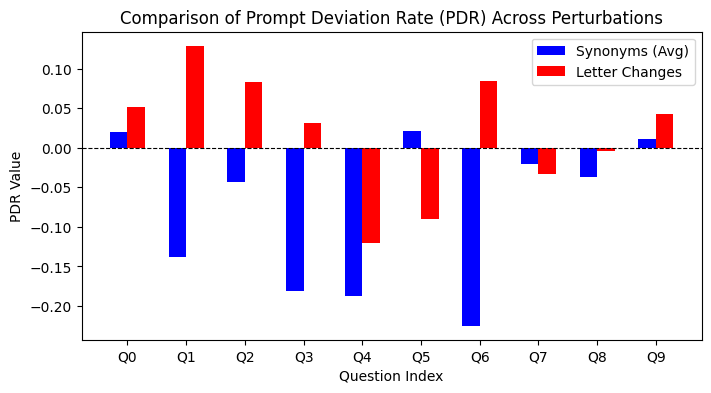

In [373]:
import matplotlib.pyplot as plt
import numpy as np




# Question indices
question_indices = np.arange(len(pdr_results_synonyms_pdr_only))

# Plot the bar chart
bar_width = 0.3
plt.figure(figsize=(8, 4))

plt.bar(question_indices - bar_width/2, pdr_results_synonyms_pdr_only, bar_width, label="Synonyms (Avg)", color='b')
plt.bar(question_indices + bar_width/2, pdr_results_letter_changes_pdr_only, bar_width, label="Letter Changes", color='r')

# Labels and title
plt.xlabel("Question Index")
plt.ylabel("PDR Value")
plt.title("Comparison of Prompt Deviation Rate (PDR) Across Perturbations")
plt.xticks(question_indices, [f"Q{i}" for i in question_indices])
plt.axhline(y=0, color='black', linewidth=0.8, linestyle="--")  # Zero reference line
plt.legend()

# Show the plot
plt.show()


In [379]:
print("Mean PDR Values:")
print("Synonyms (Avg):", np.mean(pdr_results_synonyms_pdr_only))
print("Letter Changes:", np.mean(pdr_results_letter_changes_pdr_only))
print("Synonyms (LLM as a judge):", np.mean(pdr_results_synonyms_llm_pdr_only))
print("Letter Changes (LLM as a judge):", np.mean(pdr_results_letter_changes_llm_pdr_only))


Mean PDR Values:
Synonyms (Avg): -0.07808055564425943
Letter Changes: 0.017408274102658737
Synonyms (LLM as a judge): -0.07808055564425943
Letter Changes (LLM as a judge): -0.06810844895888214


In [386]:
print("Mean Similarity Scores:")
print("LLM as a judge Scores:")
print("  Original:", np.mean(llms_similarity_scores_main))
print("  Synonyms (Averaged):", np.mean(llms_similarity_scores_synonyms_averaged))
print("  Letter Changes (Averaged):", np.mean(llms_similarity_scores_letter_changes))

print("\nEmbedding Scores:")
print("  Original:", np.mean(similarity_scores_main))
print("  Synonyms (Averaged):", np.mean(similarity_scores_synonyms))
print("  Letter Changes (Averaged):", np.mean(similarity_scores_all_averaged))





Mean Similarity Scores:
LLM as a judge Scores:
  Original: 0.8989999999999998
  Synonyms (Averaged): 0.9629999999999999
  Letter Changes (Averaged): 0.9530000000000001

Embedding Scores:
  Original: 0.7061325900955124
  Synonyms (Averaged): 0.6801651396738765
  Letter Changes (Averaged): 0.6901797117898241


In [388]:
# Calculate PDR values from mean similarity scores
llm_pdr_synonyms = 1 - (0.8989999999999998 / 0.9629999999999999)
llm_pdr_letter_changes = 1 - (0.8989999999999998 / 0.9530000000000001)

embedding_pdr_synonyms = 1 - (0.6801651396738765 / 0.7061325900955124)
embedding_pdr_letter_changes = 1 - (0.6901797117898241 / 0.7061325900955124)

print("\nPDR Values from Mean Similarity Scores:")
print("LLM as judge:")
print(f"  Synonyms PDR: {llm_pdr_synonyms:.4f}")
print(f"  Letter Changes PDR: {llm_pdr_letter_changes:.4f}")
print("\nEmbedding based:")
print(f"  Synonyms PDR: {embedding_pdr_synonyms:.4f}") 
print(f"  Letter Changes PDR: {embedding_pdr_letter_changes:.4f}")



PDR Values from Mean Similarity Scores:
LLM as judge:
  Synonyms PDR: 0.0665
  Letter Changes PDR: 0.0567

Embedding based:
  Synonyms PDR: 0.0368
  Letter Changes PDR: 0.0226
